In [1]:
import pandas as pd
# Load the dataset
data = pd.read_csv("Allergen_Status_of_Food_Products.csv")

# Display the first few rows of the dataset for exploration
data.head()


,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Price ($),Customer rating (Out of 5),Prediction
0,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",10.15,3.1,Contains
1,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",6.17,4.5,Contains
2,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",19.65,4.1,Contains
3,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",17.48,4.7,Contains
4,Cheddar Cheese,Cheese,NaN,NaN,Salt,Dairy,10.83,3.7,Contains


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model

In [4]:

# Preprocessing the data
data = pd.read_csv("Allergen_Status_of_Food_Products.csv")

# Fill NaN values with empty strings in the relevant columns
data = data.fillna('')

# Encoding the input features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Food Product'] + " " + 
                             data['Main Ingredient'] + " " + 
                             data['Sweetener'] + " " + 
                             data['Fat/Oil'] + " " + 
                             data['Seasoning'])

# Preparing the target variable for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['Allergens'].str.split(', '))

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:

# Create the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Train the model with the dense data
history = model.fit(X_train_dense, y_train, epochs=1000, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set using the dense data
loss, accuracy = model.evaluate(X_test_dense, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Make predictions using the dense data
predictions = model.predict(X_test_dense)
model.save('ALE.h5')  # creates a HDF5 file 'ALE.h5'





Epoch 1/1000


8/8 [==============================] - 1s 20ms/step - loss: 0.6697 - accuracy: 0.0863 - val_loss: 0.6337 - val_accuracy: 0.2031
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.1333 - val_loss: 0.5697 - val_accuracy: 0.3750
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.5398 - accuracy: 0.1333 - val_loss: 0.4798 - val_accuracy: 0.4219
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.4479 - accuracy: 0.2314 - val_loss: 0.3693 - val_accuracy: 0.4688
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.3518 - accuracy: 0.2588 - val_loss: 0.2632 - val_accuracy: 0.5000
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.2665 - accuracy: 0.3569 - val_loss: 0.1902 - val_accuracy: 0.5625
Epoch 7/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.2032 - accuracy: 0.3725 - val_loss: 0.1537 - val_accuracy: 0.5625
Epoch 8/1000
8/8

c:\Users\rjh20\.conda\envs\170Project\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
trained_model = load_model('ALE.h5')

### Optuna Tunning, it takes a long time. 

In [29]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(trial):
    # Hyperparameters to be tuned by Optuna
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.1, 0.7)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.1, 0.7)

    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    units_layer_1 = trial.suggest_int('units_layer_1', 64, 256)
    units_layer_2 = trial.suggest_int('units_layer_2', 32, 128)
    activation_function1 = trial.suggest_categorical('activation1', ['relu', 'sigmoid', 'tanh'])
    activation_function2 = trial.suggest_categorical('activation2', ['relu', 'sigmoid', 'tanh'])

    # Model architecture
    model = Sequential()
    model.add(Dense(units_layer_1, input_dim=X_train.shape[1], activation=activation_function1))
    model.add(Dropout(dropout_rate1))
    model.add(Dense(units_layer_2, activation=activation_function2))
    model.add(Dropout(dropout_rate2))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))

    # Compile model
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

def objective(trial):
     # Create and train model
    model = create_model(trial)
    X_train_dense = X_train.toarray()  # Assuming X_train is in sparse format
    model.fit(X_train_dense, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    X_test_dense = X_test.toarray()  # Assuming X_test is in sparse format
    loss, accuracy = model.evaluate(X_test_dense, y_test, verbose=0)
    return accuracy  # Return accuracy
# Optuna study (maximize accuracy)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Output best trial information
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
best_trial = study.best_trial



[I 2023-11-28 00:02:32,601] A new study created in memory with name: no-name-25b2f5c1-f8bf-4f5c-b3c7-063bd444c735
[I 2023-11-28 00:03:05,422] Trial 0 finished with value: 0.800000011920929 and parameters: {'dropout_rate1': 0.19563531022292624, 'dropout_rate2': 0.40649155462324593, 'lr': 7.20987249443428e-05, 'units_layer_1': 224, 'units_layer_2': 42, 'activation1': 'tanh', 'activation2': 'tanh'}. Best is trial 0 with value: 0.800000011920929.
[I 2023-11-28 00:03:36,260] Trial 1 finished with value: 0.737500011920929 and parameters: {'dropout_rate1': 0.17446820453226453, 'dropout_rate2': 0.26775398559583274, 'lr': 4.6175230776094094e-05, 'units_layer_1': 132, 'units_layer_2': 39, 'activation1': 'sigmoid', 'activation2': 'tanh'}. Best is trial 0 with value: 0.800000011920929.
[I 2023-11-28 00:04:10,696] Trial 2 finished with value: 0.762499988079071 and parameters: {'dropout_rate1': 0.4507340863462945, 'dropout_rate2': 0.5047296846503864, 'lr': 8.305613081615362e-05, 'units_layer_1': 157

Number of finished trials: 500
Best trial: {'dropout_rate1': 0.12941757164662107, 'dropout_rate2': 0.15634971885677032, 'lr': 3.123287405483054e-05, 'units_layer_1': 194, 'units_layer_2': 86, 'activation1': 'tanh', 'activation2': 'relu'}


In [30]:
# Train final model with best hyperparameters
best_model = create_model(best_trial)
X_train_dense = X_train.toarray()
best_model_history = best_model.fit(X_train_dense, y_train, epochs=1000, batch_size=32, validation_split=0.2)
loss, accuracy = best_model.evaluate(X_test_dense, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Save the final model
best_model.save('best_model.h5')

Epoch 1/1000
8/8 [==============================] - 1s 21ms/step - loss: 0.7009 - accuracy: 0.0510 - val_loss: 0.6947 - val_accuracy: 0.0312
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.6992 - accuracy: 0.0314 - val_loss: 0.6921 - val_accuracy: 0.0312
Epoch 3/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.0353 - val_loss: 0.6894 - val_accuracy: 0.0469
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.0510 - val_loss: 0.6868 - val_accuracy: 0.0469
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.0353 - val_loss: 0.6842 - val_accuracy: 0.0469
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.0392 - val_loss: 0.6816 - val_accuracy: 0.0469
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.6848 - accuracy: 0.0510 - val_loss: 0.6790 - val_accuracy: 0.0469
Epoch 8/1000
8/8 [=

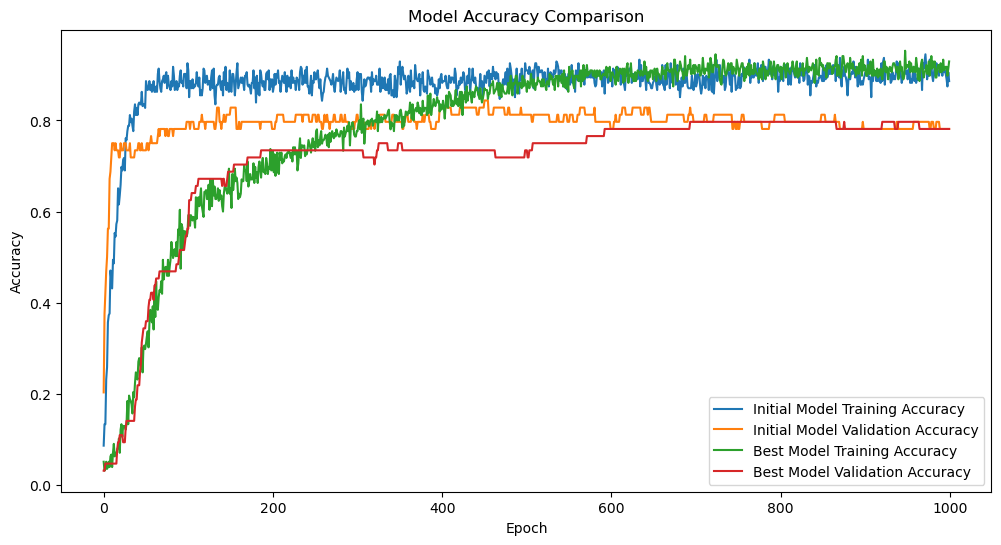

In [34]:
import matplotlib.pyplot as plt

# Plotting accuracies
plt.figure(figsize=(12, 6))

# Initial Model
plt.plot(history.history['accuracy'], label='Initial Model Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Initial Model Validation Accuracy')

# Best Model
plt.plot(best_model_history.history['accuracy'], label='Best Model Training Accuracy')
plt.plot(best_model_history.history['val_accuracy'], label='Best Model Validation Accuracy')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [35]:
import numpy as np
# Load the initial and final models
initial_model = load_model('ALE.h5')
final_model = load_model('best_model.h5')

# Function to get feature importance from a model
def get_feature_importance(model, vectorizer):
    # Get the weights of the first Dense layer
    weights = model.layers[0].get_weights()[0]
    
    # Sum the absolute values of weights for each feature
    feature_importance = np.sum(np.abs(weights), axis=1)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    return importance_df

# Get feature importance for both models
initial_importance = get_feature_importance(initial_model, vectorizer)
final_importance = get_feature_importance(final_model, vectorizer)

# Display top 10 important features for each model
print("Initial Model Feature Importance:")
print(initial_importance.head(10))

print("\nBest Model Feature Importance:")
print(final_importance.head(10))


Initial Model Feature Importance:
         Feature  Importance
117         eggs   28.199451
131        flour   24.532597
179      lasagna   23.867008
197   margherita   23.349644
252       peanut   23.154419
263          pie   23.119902
111        dough   22.948040
293  ratatouille   22.693060
281   quesadilla   22.531979
276       prawns   22.259102

Best Model Feature Importance:
        Feature  Importance
131       flour   17.251373
327      shrimp   16.019587
117        eggs   15.927656
333         soy   15.624046
252      peanut   15.178944
308      salmon   14.778857
197  margherita   14.516620
179     lasagna   14.492985
111       dough   14.117113
276      prawns   13.963343


### Using the untuned model

In [53]:
trained_model = load_model('ALE.h5')
def predict_allergens_with_user_input(model, vectorizer, mlb, threshold=0.5):
    """
    Predicts allergens in a given food product based on user inputted ingredients
    and provides the likelihood of each allergen.

    Parameters:
    - model: Trained machine learning model for prediction.
    - vectorizer: CountVectorizer fitted on the training data.
    - mlb: MultiLabelBinarizer fitted on the training data.
    - threshold: Threshold for predicting the presence of an allergen (default is 0.5).

    Returns:
    - A dictionary with allergens and their likelihood.
    """

    # User input
    food_product = input("Enter Food Product Name: ")
    main_ingredient = input("Enter Main Ingredient: ")
    sweetener = input("Enter Sweetener (or None): ")
    fat_oil = input("Enter Fat/Oil (or None): ")
    seasoning = input("Enter Seasoning (or None): ")

    # Combining the input data and transforming it using the vectorizer
    combined_input = vectorizer.transform([f"{food_product} {main_ingredient} {sweetener} {fat_oil} {seasoning}"])

    # Getting model predictions
    pred_probabilities = model.predict(combined_input.toarray())[0]

    # Creating a dictionary of allergen probabilities
    allergen_probabilities = {allergen: prob for allergen, prob in zip(mlb.classes_, pred_probabilities)}
    if '' in allergen_probabilities and allergen_probabilities[''] > threshold:
        return f"Does not contain allergens (Probability: {allergen_probabilities['']:.6f})"
    # Filtering to include only allergens with probability above the threshold
    
    likely_allergens = {allergen: prob for allergen, prob in allergen_probabilities.items() if prob > threshold}
    if '' in likely_allergens:
        return f"Does not contain allergens (Probability: {allergen_probabilities['']:.6f})"
    else: 
        return likely_allergens
  

allergen_predictions = predict_allergens_with_user_input(trained_model, vectorizer, mlb)
allergen_predictions


1/1 [==============================] - 0s 51ms/step


'Does not contain allergens (Probability: 0.986715)'

In [36]:
best_trained_model = load_model('best_model.h5')
def predict_allergens_with_user_input(model, vectorizer, mlb, threshold=0.5):
    """
    Predicts allergens in a given food product based on user inputted ingredients
    and provides the likelihood of each allergen.

    Parameters:
    - model: Trained machine learning model for prediction.
    - vectorizer: CountVectorizer fitted on the training data.
    - mlb: MultiLabelBinarizer fitted on the training data.
    - threshold: Threshold for predicting the presence of an allergen (default is 0.5).

    Returns:
    - A dictionary with allergens and their likelihood.
    """

    # User input
    food_product = input("Enter Food Product Name: ")
    main_ingredient = input("Enter Main Ingredient: ")
    sweetener = input("Enter Sweetener (or None): ")
    fat_oil = input("Enter Fat/Oil (or None): ")
    seasoning = input("Enter Seasoning (or None): ")

    # Combining the input data and transforming it using the vectorizer
    combined_input = vectorizer.transform([f"{food_product} {main_ingredient} {sweetener} {fat_oil} {seasoning}"])

    # Getting model predictions
    pred_probabilities = model.predict(combined_input.toarray())[0]

    # Creating a dictionary of allergen probabilities
    allergen_probabilities = {allergen: prob for allergen, prob in zip(mlb.classes_, pred_probabilities)}
    if '' in allergen_probabilities and allergen_probabilities[''] > threshold:
        return f"Does not contain allergens (Probability: {allergen_probabilities['']:.6f})"
    # Filtering to include only allergens with probability above the threshold
    
    likely_allergens = {allergen: prob for allergen, prob in allergen_probabilities.items() if prob > threshold}
    if '' in likely_allergens:
        return f"Does not contain allergens (Probability: {allergen_probabilities['']:.6f})"
    else: 
        return likely_allergens
  

allergen_predictions = predict_allergens_with_user_input(best_trained_model, vectorizer, mlb)
allergen_predictions


1/1 [==============================] - 0s 42ms/step


{'Dairy': 0.981132, 'Wheat': 0.73444}